Start Position:  (2000, 5600)
End Position:  (2400, 6000)


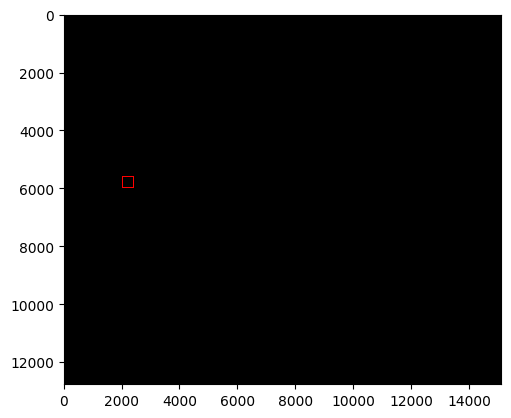

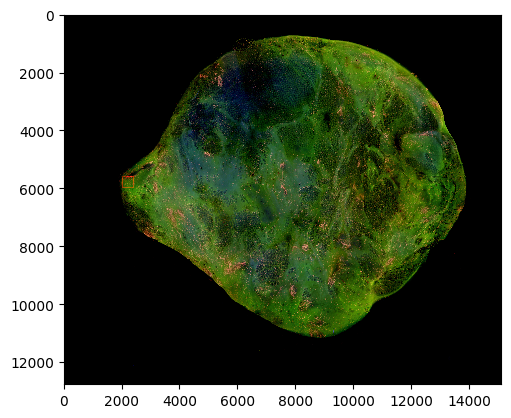

In [1]:
#==================================================================
#Program: patchVisualizationExample
#Version: 1.0
#Author: David Helminiak
#Date Created: 12 November 2024
#Date Last Modified: 12 November 2024
#Description: Visualize a rectangle around a given patch to indicate its prediction status
#Operation: Move back into main program directory (./RANDS/) before running.
#==================================================================

#Have the notebook fill more of the display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:80% !important; }</style>"))

#Load external libraries
#======================================================
import os
import cv2
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

#Define helper functions
#======================================================
#Export lossless RGB image data to disk
def exportImage(filename, image, exportLosslessFlag):
    if exportLosslessFlag: 
        filename += '.tif'
        writeSuccess = cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR), params=(cv2.IMWRITE_TIFF_COMPRESSION, 1))
    else: 
        filename += '.jpg'
        writeSuccess = cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), exportQuality])
    if not writeSuccess: sys.exit('\nError - Unable to write file to disk; please verify directory location exists and has sufficient free space: ' + filename + '\n')
    return filename

#OpenCV does not output sharp corners with its rectangle method...unless it's filled in
def rectangle(image, startPos, endPos, color):
    image = cv2.rectangle(image, startPos, endPos, color, -1)
    image = cv2.rectangle(image, (startPos[0]+gridThicknessOffset, startPos[1]+gridThicknessOffset), (endPos[0]-gridThicknessOffset, endPos[1]-gridThicknessOffset), (0, 0, 0), -1)
    return image


#Library setup
#======================================================
#Raise the maximum image size for opencv; note that this can allow for decompression bomb DOS attacks if an untrusted image ends up as an input
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()

#Operational parameters
#Deprecated data folder used BLOCKS directory, they do not have the exact same data!
#======================================================
#Define the paths to the WSI and a patch
wsi_filename = "./DATA/PATCHES/INPUT_WSI/2_1.jpg"
patch_filename = "./DATA/PATCHES/INPUT_BLOCKS/2_1/PS2_1_1_5600_2000.tif"

#When splitting WSI images, what size should the resulting patches be (default: 400)
#Should remain consistent with patch sizes given for training
patchSize = 400

#How thick should the grid lines be when generating overlay images (default: 50)
gridThickness = 50

#Should images be saved to lossless (.tif) or compressed (.jpg) image format (default: False)
#Any images that are anticipated to be reused (such as extracted patches), should be hardcoded to be saved in a lossless format by default
exportLossless = False

#For .jpg image outputs, what should the compression quality (%) be (default: 95)
#WARNING: Setting to 100 is not sufficient to generate in lossless/exact outputs; if that is desired, use overlayLossless instead! 
exportQuality = 95

#What weight should be used when overlaying data
overlayWeight = 0.5


#Functional/derived parameters
#======================================================
#Define general labels and values to use; black for background, red for malignant, green for benign
labelBenign, labelMalignant, labelExclude = '0', '1', '2'
valueBenign, valueMalignant, valueBackground = int(labelBenign), int(labelMalignant), 2
cmapClasses = colors.ListedColormap(['lime', 'red', 'black'])

#Determine offset to avoid overlapping squares in grid visualization
gridThicknessOffset = gridThickness//2


#Main program code
#======================================================
#Extract metadata from the filename
sampleName, sampleSide, patchIndexActual, startRow, startColumn = os.path.basename(patch_filename).split('.tif')[0].split('_') 
sampleSide, patchIndexActual, startRow, startColumn = int(sampleSide), int(patchIndexActual), int(startRow), int(startColumn)

#Load WSI image 
imageWSI = cv2.cvtColor(cv2.imread(wsi_filename, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

#Make an example prediction for a single patch (valueBenign, valueMalignant, valueBackground)
patchIndex = 0
patchPredictions = np.asarray([valueMalignant])

#Create an empty array/image that will store predictions and overlay onto WSI
gridOverlay_Predictions = np.zeros(imageWSI.shape, dtype=np.uint8)

#Map prediction to predefined colormap
colorsPredictions = (cmapClasses(patchPredictions)[:,:3].astype(np.uint8)*255).tolist()

#Reverse order for indexing rows/columns and compute end coordinate
posStart, posEnd = (startColumn, startRow), (startColumn+patchSize, startRow+patchSize)

#Print out the start and end position (reversed from filename for rectangle function: column, row)
print('Start Position: ', posStart)
print('End Position: ', posEnd)

#Add rectangle for a patch to the global overlay
gridOverlay_Predictions = rectangle(gridOverlay_Predictions, posStart, posEnd, colorsPredictions[patchIndex])

#Export the prediction overlay on its own
_ = exportImage('./predictionsGrid_'+sampleName, gridOverlay_Predictions, exportLossless)

#Visualize the prediction overlay, without interpolation
plt.imshow(gridOverlay_Predictions, interpolation='none')
plt.show(); plt.close()

#Combine the prediction overlay with the WSI
imageWSI_Predictions = cv2.addWeighted(imageWSI, 1.0, gridOverlay_Predictions, overlayWeight, 0.0)

#Visualize the combined image, without interpolation
plt.imshow(imageWSI_Predictions, interpolation='none')
plt.show(); plt.close()

#Export the combined image
_ = exportImage('./overlaid_predictionsGrid_'+sampleName, imageWSI_Predictions, exportLossless)

